## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
# !wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o ml-1m.zip
!cat ml-1m/README

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5778k  100 5778k    0     0  1115k      0  0:00:05  0:00:05 --:--:-- 1396k
Archive:  ml-1m.zip
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under the following conditions:

     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research G

In [1]:
import pandas as pd
import numpy as np
from typing import Union

In [2]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [3]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [4]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [5]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [6]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [7]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, np.int64(3009))

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [8]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:

    users_length = df['user_id'].max() + 1 
    items_lenght = df['item_id'].max() + 1 

    matrix = np.zeros((users_length, items_lenght))

    for _, row in df.iterrows():
        matrix[row['user_id'], row['item_id']] = row['rating']

    return matrix

In [9]:
interactions = df_to_matrix(df_train)

In [10]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:

    users_length = df['user_id'].max() + 1 
    items_lenght = df['item_id'].max() + 1 

    rows = np.array(df['user_id'])
    cols = np.array(df['item_id'])
    values = np.array(df['rating'], dtype=float) 

    coo_matix = coo_array((values, (rows, cols)), shape=(users_length, items_lenght))
    
    return coo_matix

In [11]:
coo_interactions = df_to_coo(df_train)

In [12]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [13]:
import scipy.sparse.linalg
import scipy.linalg

def make_svd(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)
    
    if isinstance(interactions, np.ndarray):
        U, s, V = scipy.linalg.svd(interactions, full_matrices = False)

        if n_singular_values != -1:
            U = U[:, :n_singular_values]    
            s = s[:n_singular_values]        
            V = V[:n_singular_values, :] 
        
    elif isinstance(interactions, coo_array):
        singular_numbers = min(interactions.shape) - 1 if n_singular_values == -1 else n_singular_values
        
        U, s, V = scipy.sparse.linalg.svds(interactions, k=singular_numbers)
        U, s, V = U[:, ::-1], s[::-1], V[::-1, :]

    S = np.diag(s)
            
    return U, S, V 

In [14]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [15]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [16]:
def make_svd_recommendations(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы 
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал
    
    U, S, V = make_svd(interactions, n_singular_values)
    matrix_restored = U @ S @ V

    if isinstance(interactions, coo_array):
         interactions = interactions.tocsr().toarray()  

    mask = interactions > 0
        
    matrix_restored[mask] = - np.inf
    
    recommendations = np.argsort(matrix_restored, axis=1)[:, - top_k:]
    
    return recommendations #shape ~ [n_users, top_k]

In [17]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [18]:
# Создает датафрейм, в котором собраны ground truth айтемы и предсказания по тестовым пользователям
def get_eval_df(df_test, predictions):
    test_users = np.sort(df_test.user_id.unique())
    predictions_test = predictions[test_users]

    gt_items = df_test.groupby('user_id').item_id.agg(list).reindex(test_users)

    df_eval = pd.DataFrame({
        'user_id': test_users,
        'gt_items': gt_items.values,  
        'predicted_items': [list(row) for row in predictions_test]
    })

    return df_eval

In [19]:
def dcg(scores):
    if len(scores) == 0:
        return 0.0
        
    num = np.power(2, scores) - 1
    den = np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)
    metric = np.sum(num / den)
    
    return metric

В семинаре была дана следующая реализация:
- `at = len(predicted)`
- `relevance = np.array([1 if item in predicted else 0 for item in gt_items])`
- `idcg = dcg(np.sort(relevance)[::-1][:at])`.

То есть мы проверяем действия из тестового датасета на вхождение в рекомендации. При этом обсудили, что корректнее проверять рекомендации на вхождения в тест. 

Различия в реализациях будут влиять на метрику. Для этого шага вычислю ее обоими способами, но дальше в заданиях как предпочтительную использую вариант с присвоением вхождения рекомендациям в тест, а не наоборот (то есть решение не из семинара).

In [23]:
def ndcg_seminar(gt_items, predicted):
    if len(gt_items) == 0: 
        return 0.0
        
    at = len(predicted)
    
    relevance = np.array([1 if item in predicted else 0 for item in gt_items])
    
    rank_dcg = dcg(relevance)
    idcg = dcg(np.sort(relevance)[::-1][:at])
    
    metric = 0.0 if (idcg == 0) or (rank_dcg == 0) else rank_dcg / idcg

    return metric


def ndcg(gt_items, predicted):
    if len(gt_items) == 0: 
        return 0.0

    relevance = np.array([1 if item in gt_items else 0 for item in predicted])
    
    rank_dcg = dcg(relevance)
    idcg = dcg(np.sort(relevance)[::-1])
    
    metric = 0.0 if (idcg == 0) or (rank_dcg == 0) else rank_dcg / idcg

    return metric


def evaluate_recommender(df_test, predictions, ndcg_sem=False):
    ndcg_list = []
    
    df_eval = get_eval_df(df_test, predictions)

    
    for idx, row in df_eval.iterrows():
        if ndcg_sem:
            ndcg_list.append(ndcg_seminar(row.gt_items, row.predicted_items))
        else:
            ndcg_list.append(ndcg(row.gt_items, row.predicted_items))
            
    return np.mean(ndcg_list)

In [24]:
import time
import matplotlib.pyplot as plt

def plot_graphs(interactions: Union[np.ndarray, coo_array], df_test, top_k: int = 100, ndcg_sem=False):
    ndcg_metrics = {}
    times = {}
    singular_values = [1, 10, 50, 100, 200, 1000]
    counter = len(singular_values)

    for n_singular_values in singular_values:
        start_time = time.time()
            
        predictions = make_svd_recommendations(interactions, n_singular_values, top_k) 
        
        ndcg_metrics[n_singular_values] = evaluate_recommender(df_test, predictions, ndcg_sem)
        times[n_singular_values] = time.time() - start_time

        counter -= 1
        print(f'singular {n_singular_values} — done, to do: {counter} values')

    # Viz
    plt.figure(figsize=(10, 5))

    # NDCG
    plt.subplot(1, 2, 1)
    plt.plot(ndcg_metrics.keys(), ndcg_metrics.values(), marker='o', linestyle='-')
    plt.xlabel('Singular Value')
    plt.ylabel('Metric Value')
    plt.title(f'NDCG@{top_k} Dependency on Singular Values')
    plt.grid()

    # Time
    plt.subplot(1, 2, 2)
    plt.plot(times.keys(), times.values(), marker='o', linestyle='-')
    plt.xlabel('Singular Value')
    plt.ylabel('Time, seconds')
    plt.title('SVD Working Time Dependency on Singular Values')
    plt.grid()

    plt.show()
    
    return plt.show()

Качество метрики из семинара

singular 1 — done, to do: 5 values
singular 10 — done, to do: 4 values
singular 50 — done, to do: 3 values
singular 100 — done, to do: 2 values
singular 200 — done, to do: 1 values
singular 1000 — done, to do: 0 values


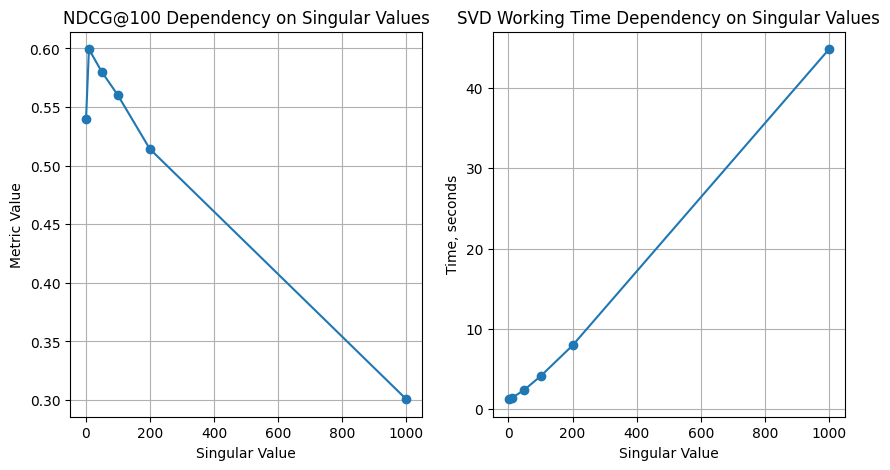

In [26]:
plot_graphs(coo_interactions, df_test, ndcg_sem=True)

Качество метрики, рассчитанной по вхождению рекомендаций в тест (используем везде в дальнейшем)

singular 1 — done, to do: 5 values
singular 10 — done, to do: 4 values
singular 50 — done, to do: 3 values
singular 100 — done, to do: 2 values
singular 200 — done, to do: 1 values
singular 1000 — done, to do: 0 values


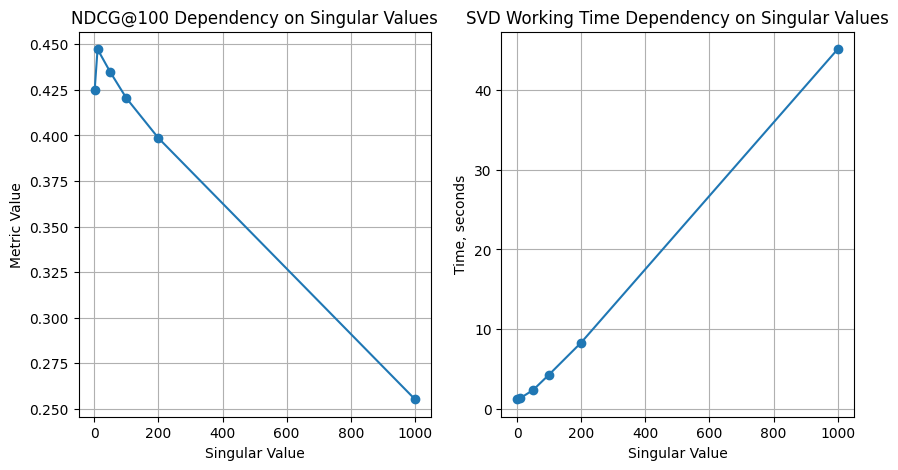

In [27]:
plot_graphs(coo_interactions, df_test)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [28]:
import implicit
from scipy.sparse import csr_matrix

def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array], 
    top_k: int = 100, 
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    if isinstance(interactions, np.ndarray):
        interactions = coo_array(interactions)

    model = implicit.als.AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        alpha=alpha,
        random_state=42
    )
    
    interactions_csr = csr_matrix(interactions)
    
    model.fit(interactions_csr)

    users = np.arange(interactions.shape[0])
    items, scores = model.recommend(users, interactions_csr, N=top_k, filter_already_liked_items=True)
    
    return items, model # возвращаем model, чтобы потом использовать ее в explain

In [29]:
recs, als = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

  0%|          | 0/15 [00:00<?, ?it/s]

In [30]:
# дефолтная проверка качества
evaluate_recommender(df_test, recs)

np.float64(0.4999137188407219)

Дефолтная проверка (без подбора гиперпараметров), дает качество немного выше, чем самое высокое из детектируемых (n_singular_values=10) на SVD

In [34]:
import optuna

def objective(trial):
    n_factors = trial.suggest_int('n_factors', 10, 1000, log=True)
    alpha = trial.suggest_float('alpha', 1.0, 20.0, log=True)
    regularization = trial.suggest_float('regularization', 0.001, 2.0, log=True)

    recs, als = make_als_recommendations(interactions, 
                                         n_factors=n_factors,
                                         alpha=alpha,
                                         regularization=regularization
                                        )  

    ndcg_values = evaluate_recommender(df_test, recs)

    return ndcg_values

In [35]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_ndcg = study.best_value

[I 2025-03-02 19:05:10,285] A new study created in memory with name: no-name-0b5582cd-3335-408b-baa7-b1dedca4b196


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:05:12,364] Trial 0 finished with value: 0.5154306816200745 and parameters: {'n_factors': 28, 'alpha': 1.470988466896334, 'regularization': 0.0016604013636341776}. Best is trial 0 with value: 0.5154306816200745.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:05:16,100] Trial 1 finished with value: 0.46812396382231597 and parameters: {'n_factors': 89, 'alpha': 7.085170846831894, 'regularization': 0.026894757851671454}. Best is trial 0 with value: 0.5154306816200745.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:05:27,779] Trial 2 finished with value: 0.4586976179838788 and parameters: {'n_factors': 241, 'alpha': 1.0966281837287268, 'regularization': 0.001638463526074343}. Best is trial 0 with value: 0.5154306816200745.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:05:30,222] Trial 3 finished with value: 0.5162943217925803 and parameters: {'n_factors': 42, 'alpha': 1.0662417942841458, 'regularization': 0.046449784846489796}. Best is trial 3 with value: 0.5162943217925803.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:05:32,036] Trial 4 finished with value: 0.5311538581681303 and parameters: {'n_factors': 11, 'alpha': 2.060308195935339, 'regularization': 0.10455022785661255}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:06:05,560] Trial 5 finished with value: 0.42739589098231695 and parameters: {'n_factors': 575, 'alpha': 15.171532208630968, 'regularization': 0.0028604707975895256}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:06:41,287] Trial 6 finished with value: 0.3880461795534247 and parameters: {'n_factors': 656, 'alpha': 1.6492712629482644, 'regularization': 0.24785940878459922}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:07:21,538] Trial 7 finished with value: 0.41173195946649793 and parameters: {'n_factors': 684, 'alpha': 5.99339548450812, 'regularization': 0.0040941532975010304}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:07:25,011] Trial 8 finished with value: 0.49903709616750086 and parameters: {'n_factors': 66, 'alpha': 2.6238477754451304, 'regularization': 0.00308248818520883}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:07:27,182] Trial 9 finished with value: 0.46844049985982605 and parameters: {'n_factors': 30, 'alpha': 11.93016689991651, 'regularization': 0.1403978358710869}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:07:28,983] Trial 10 finished with value: 0.5219963065011336 and parameters: {'n_factors': 12, 'alpha': 3.1434982762382675, 'regularization': 1.282630236061941}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:07:30,778] Trial 11 finished with value: 0.5279691718315332 and parameters: {'n_factors': 10, 'alpha': 3.0917630466458634, 'regularization': 1.9828852637249441}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:07:32,559] Trial 12 finished with value: 0.5280315509617357 and parameters: {'n_factors': 10, 'alpha': 3.0184688339113133, 'regularization': 1.5704943426199849}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:07:34,518] Trial 13 finished with value: 0.5204536068812873 and parameters: {'n_factors': 17, 'alpha': 2.256859880932861, 'regularization': 0.5305260930577727}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:07:36,501] Trial 14 finished with value: 0.5054966830924247 and parameters: {'n_factors': 19, 'alpha': 4.618676935545588, 'regularization': 0.017243801346244942}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:07:46,918] Trial 15 finished with value: 0.46521125386191914 and parameters: {'n_factors': 213, 'alpha': 1.8669312422956201, 'regularization': 0.09630843508070941}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:07:48,704] Trial 16 finished with value: 0.523089594927718 and parameters: {'n_factors': 10, 'alpha': 4.266343463932768, 'regularization': 0.7701567151393692}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:07:57,280] Trial 17 finished with value: 0.4607413541611112 and parameters: {'n_factors': 173, 'alpha': 8.6537294023773, 'regularization': 0.3743317806311214}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:07:59,969] Trial 18 finished with value: 0.48873971174562214 and parameters: {'n_factors': 52, 'alpha': 4.149564915233913, 'regularization': 0.007388545987667136}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:08:01,882] Trial 19 finished with value: 0.5211782418067454 and parameters: {'n_factors': 17, 'alpha': 2.209719295417543, 'regularization': 0.08901715841065937}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:08:04,100] Trial 20 finished with value: 0.5170583587878839 and parameters: {'n_factors': 34, 'alpha': 1.3129321289443132, 'regularization': 0.24665062464384555}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:08:05,888] Trial 21 finished with value: 0.5241327103268044 and parameters: {'n_factors': 11, 'alpha': 3.2410187725698933, 'regularization': 1.6960418517307037}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:08:07,838] Trial 22 finished with value: 0.5077954567228359 and parameters: {'n_factors': 20, 'alpha': 3.1150954849700634, 'regularization': 1.9635432972447013}. Best is trial 4 with value: 0.5311538581681303.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:08:09,616] Trial 23 finished with value: 0.5319482986634834 and parameters: {'n_factors': 10, 'alpha': 2.0390732592749132, 'regularization': 0.8524606388647672}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:08:11,672] Trial 24 finished with value: 0.5158025495415963 and parameters: {'n_factors': 23, 'alpha': 1.9830857058631128, 'regularization': 0.9619245139877017}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:08:13,527] Trial 25 finished with value: 0.5191013144125897 and parameters: {'n_factors': 15, 'alpha': 2.378493400094216, 'regularization': 0.5152748122023434}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:08:15,359] Trial 26 finished with value: 0.52571867829085 and parameters: {'n_factors': 14, 'alpha': 1.4515082989110115, 'regularization': 0.18947898685821044}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:08:17,342] Trial 27 finished with value: 0.4952754639028917 and parameters: {'n_factors': 24, 'alpha': 5.252109599644716, 'regularization': 0.05067132192391767}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:08:22,167] Trial 28 finished with value: 0.4805575393039312 and parameters: {'n_factors': 124, 'alpha': 3.7207109862553365, 'regularization': 0.8233344714936579}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:09:44,049] Trial 29 finished with value: 0.3468831116547377 and parameters: {'n_factors': 990, 'alpha': 1.7807698162403338, 'regularization': 0.4075985808806571}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:09:46,509] Trial 30 finished with value: 0.5125335702406607 and parameters: {'n_factors': 43, 'alpha': 1.316244622926108, 'regularization': 0.011250504173524044}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:09:48,297] Trial 31 finished with value: 0.5236817645882649 and parameters: {'n_factors': 12, 'alpha': 2.732554169507604, 'regularization': 1.1985671787175218}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:09:50,086] Trial 32 finished with value: 0.5285563718815296 and parameters: {'n_factors': 10, 'alpha': 2.799000774952133, 'regularization': 1.7483563872848737}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:09:51,956] Trial 33 finished with value: 0.5239233122527651 and parameters: {'n_factors': 14, 'alpha': 2.0675628279786005, 'regularization': 0.6601661295499446}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:09:53,744] Trial 34 finished with value: 0.529823723509085 and parameters: {'n_factors': 10, 'alpha': 2.603403212905296, 'regularization': 0.001001582950633335}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:09:55,913] Trial 35 finished with value: 0.5129499793224548 and parameters: {'n_factors': 29, 'alpha': 1.6169530293623937, 'regularization': 0.0325880497569276}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:10:13,817] Trial 36 finished with value: 0.4317028983227756 and parameters: {'n_factors': 361, 'alpha': 1.168529653370309, 'regularization': 0.0013576237941139114}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:10:17,727] Trial 37 finished with value: 0.4840043038727686 and parameters: {'n_factors': 91, 'alpha': 3.716738984539051, 'regularization': 0.0010687459917576828}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:10:19,810] Trial 38 finished with value: 0.5133202626886868 and parameters: {'n_factors': 23, 'alpha': 2.469128747007989, 'regularization': 0.06647921330624493}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:10:21,705] Trial 39 finished with value: 0.4986409768160627 and parameters: {'n_factors': 14, 'alpha': 7.690399286178251, 'regularization': 0.0061379314108128925}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:10:25,180] Trial 40 finished with value: 0.5098775414618576 and parameters: {'n_factors': 68, 'alpha': 1.0112725739784836, 'regularization': 0.019520875568820276}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:10:27,217] Trial 41 finished with value: 0.5284926580071823 and parameters: {'n_factors': 10, 'alpha': 2.816571082023049, 'regularization': 1.2705605810094733}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:10:29,106] Trial 42 finished with value: 0.4726404626436217 and parameters: {'n_factors': 13, 'alpha': 19.082517206476872, 'regularization': 1.1189042088530226}. Best is trial 23 with value: 0.5319482986634834.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:10:30,927] Trial 43 finished with value: 0.5321291738586469 and parameters: {'n_factors': 10, 'alpha': 1.9342629299221286, 'regularization': 0.34326600047653477}. Best is trial 43 with value: 0.5321291738586469.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:10:32,903] Trial 44 finished with value: 0.5224099046051889 and parameters: {'n_factors': 17, 'alpha': 1.5587875596836935, 'regularization': 0.14003329310498647}. Best is trial 43 with value: 0.5321291738586469.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:10:34,692] Trial 45 finished with value: 0.5277129429507978 and parameters: {'n_factors': 12, 'alpha': 1.8343164712279247, 'regularization': 0.3071604410884451}. Best is trial 43 with value: 0.5321291738586469.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:10:37,052] Trial 46 finished with value: 0.5048781698786811 and parameters: {'n_factors': 37, 'alpha': 2.5925114772981286, 'regularization': 0.1870158636511454}. Best is trial 43 with value: 0.5321291738586469.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:10:39,041] Trial 47 finished with value: 0.5173371604356111 and parameters: {'n_factors': 19, 'alpha': 1.9998342004766478, 'regularization': 0.6720289416803419}. Best is trial 43 with value: 0.5321291738586469.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:10:40,831] Trial 48 finished with value: 0.5368913089539311 and parameters: {'n_factors': 10, 'alpha': 1.4090795525509194, 'regularization': 0.0020124710135406803}. Best is trial 48 with value: 0.5368913089539311.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 19:10:42,672] Trial 49 finished with value: 0.5244479240603567 and parameters: {'n_factors': 16, 'alpha': 1.3682365145000857, 'regularization': 0.0027680558552798163}. Best is trial 48 with value: 0.5368913089539311.


In [36]:
print(f'Optuna iALS results: \nbest_params: {best_params}, \nbest_ndcg: {best_ndcg}')

Optuna iALS results: 
best_params: {'n_factors': 10, 'alpha': 1.4090795525509194, 'regularization': 0.0020124710135406803}, 
best_ndcg: 0.5368913089539311


##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [37]:
encodings = ['utf-8', 'ISO-8859-1', 'latin-1', 'cp1252']

for enc in encodings:
    try:
        movies_df = pd.read_csv('ml-1m/movies.dat',
                                sep='::',
                                engine='python',
                                encoding=enc,
                                names=['item_id', 'title', 'genres'],
                                header=None
                               )
        print(f'Success: {enc}')
        break
    except UnicodeDecodeError:
        print(f'Error: {enc}')

Error: utf-8
Success: ISO-8859-1


In [38]:
movies_df.head()

,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [39]:
best_als_recs, best_als = make_als_recommendations(interactions,
                                                   100,
                                                   **best_params
                                                  )

  0%|          | 0/15 [00:00<?, ?it/s]

In [41]:
users_for_explain = np.random.choice(df_test.user_id.unique(), size=10, replace=False)
users_for_explain

array([2341, 4761, 1384, 2378, 1211, 2590, 4589, 1722, 3865,  208])

In [42]:
explanation_dict = {}

for user_id in users_for_explain:
    real_user_id = user_le.inverse_transform([user_id])[0]
    predicted = best_als_recs[user_id]
    explanations = []
    
    for item_id in predicted[:5]:
        try:
            total_score, contributions, user_weights = best_als.explain(user_id, csr_matrix(interactions), item_id)

            real_item_id = item_le.inverse_transform([item_id])[0]

            recomendation = movies_df[movies_df['item_id'] == real_item_id]
            recomendation_title = recomendation.title.values[0]
            recomendation_genre = recomendation.genres.values[0]

            influencing_movies = {}
            
            for movie_id, score in contributions:
                real_item_id_i = item_le.inverse_transform([movie_id])[0]
                influencing_title = movies_df[movies_df['item_id'] == real_item_id_i].title.values[0]
                
                influencing_movies[influencing_title] = score

            explanations.append([recomendation_title, recomendation_genre, total_score, influencing_movies])
            
        except:
            continue
    
    explanation_dict[real_user_id] = explanations

In [51]:
for user_id, recommendations in explanation_dict.items():
    print(f'\nОбъяснение рекомендаций для юзера {user_id}')
    
    for rec in recommendations:
        rec_title, rec_genre, total_score, influencing_movies = rec
        print(f'\nФильм-рекомендация: {rec_title} ({rec_genre})')
        print(f'Общий вклад всех просмотренных фильмов: {total_score:.4f}')
        print(f'Влияющие фильмы (топ-5):')
        
        sorted_influences = sorted(influencing_movies.items(), key=lambda x: -x[1])
        for movie, score in sorted_influences[:5]:
            print(f'- Фильм {movie}, вклад в скор: {score:.4f}')
     
    print("\n" + "-"*60)


Объяснение рекомендаций для юзера 3017

Фильм-рекомендация: Life Is Beautiful (La Vita è bella) (1997) (Comedy|Drama)
Общий вклад всех просмотренных фильмов: 1.1842
Влияющие фильмы (топ-5):
- Фильм Schindler's List (1993), вклад в скор: 0.0180
- Фильм American Beauty (1999), вклад в скор: 0.0177
- Фильм Babe (1995), вклад в скор: 0.0171
- Фильм Wrong Trousers, The (1993), вклад в скор: 0.0167
- Фильм Shawshank Redemption, The (1994), вклад в скор: 0.0160

Фильм-рекомендация: Good Will Hunting (1997) (Drama)
Общий вклад всех просмотренных фильмов: 1.1614
Влияющие фильмы (топ-5):
- Фильм Schindler's List (1993), вклад в скор: 0.0297
- Фильм Shawshank Redemption, The (1994), вклад в скор: 0.0276
- Фильм Jerry Maguire (1996), вклад в скор: 0.0270
- Фильм Apollo 13 (1995), вклад в скор: 0.0247
- Фильм Silence of the Lambs, The (1991), вклад в скор: 0.0245

Фильм-рекомендация: Elizabeth (1998) (Drama)
Общий вклад всех просмотренных фильмов: 1.0636
Влияющие фильмы (топ-5):
- Фильм Sixth Sens

Неплохие рекомендации получаются по семейному контенту - мультфильмам (видимо тут очень устойчивая связь, т.к. в первой домашке на другом датасете и с другим алгоритмом получила такие же выводы).

Также видно, что если юзер смотрит популярную классику, то высока вероятность, что он посмотрит и другие фильмы, которые можно отнести в эту категорию (Schindler's List, Saving Private Ryan или же Terminator, Jurassic Park, Star Wars)

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

__1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)__

In [52]:
df_train_binary = df_train.copy()
df_train_binary['rating'] = 1
df_train_binary.head()

,user_id,item_id,rating,datetime
100409,0,2994,1,2000-11-30 23:49:23
100411,0,929,1,2000-11-30 23:52:33
100412,0,567,1,2000-11-30 23:51:54
100415,0,3005,1,2000-11-30 23:58:06
100416,0,3006,1,2000-11-30 23:57:50


In [53]:
interactions_binary = df_to_matrix(df_train_binary)
predictions_svd_binary = make_svd_recommendations(interactions_binary, 10, 100) 
predictions_als_binary, als_binary = make_als_recommendations(interactions_binary, 100, **best_params) 
        
ndcg_svd_binary = evaluate_recommender(df_test, predictions_svd_binary)
ndcg_als_binary = evaluate_recommender(df_test, predictions_als_binary)

print(f'SVD NDCG: {ndcg_svd_binary}\nALS NDCG: {ndcg_als_binary}')

  0%|          | 0/15 [00:00<?, ?it/s]

SVD NDCG: 0.44042027478672563
ALS NDCG: 0.5293678050567191


__2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0__

In [54]:
df_train_binary_positive = df_train.copy()
df_train_binary_positive['rating'] = (df_train_binary_positive.rating >= 4).astype(int)
df_train_binary_positive.head()

,user_id,item_id,rating,datetime
100409,0,2994,0,2000-11-30 23:49:23
100411,0,929,1,2000-11-30 23:52:33
100412,0,567,1,2000-11-30 23:51:54
100415,0,3005,0,2000-11-30 23:58:06
100416,0,3006,1,2000-11-30 23:57:50


In [55]:
interactions_binary_positive = df_to_matrix(df_train_binary_positive)
predictions_svd_binary_positive = make_svd_recommendations(interactions_binary_positive, 10, 100) 
predictions_als_binary_positive, als_binary_positive = make_als_recommendations(interactions_binary_positive, 100, **best_params) 
        
ndcg_svd_binary_positive = evaluate_recommender(df_test, predictions_svd_binary_positive)
ndcg_als_binary_positive = evaluate_recommender(df_test, predictions_als_binary_positive)

print(f'SVD NDCG: {ndcg_svd_binary_positive}\nALS NDCG: {ndcg_als_binary_positive}')

  0%|          | 0/15 [00:00<?, ?it/s]

SVD NDCG: 0.42691466554507485
ALS NDCG: 0.4970547463045566


__3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1__

In [56]:
df_train_binary_negative = df_train.copy()
df_train_binary_negative['rating'] = np.where(df_train_binary_negative['rating'] >= 4, 1, -1)
df_train_binary_negative.head()

,user_id,item_id,rating,datetime
100409,0,2994,-1,2000-11-30 23:49:23
100411,0,929,1,2000-11-30 23:52:33
100412,0,567,1,2000-11-30 23:51:54
100415,0,3005,-1,2000-11-30 23:58:06
100416,0,3006,1,2000-11-30 23:57:50


In [57]:
interactions_binary_negative = df_to_matrix(df_train_binary_negative)
predictions_svd_binary_negative = make_svd_recommendations(interactions_binary_negative, 10, 100) 
predictions_als_binary_negative, als_binary_negative = make_als_recommendations(interactions_binary_negative, 100, **best_params) 
        
ndcg_svd_binary_negative = evaluate_recommender(df_test, predictions_svd_binary_negative)
ndcg_als_binary_negative = evaluate_recommender(df_test, predictions_als_binary_negative)

print(f'SVD NDCG: {ndcg_svd_binary_negative}\nALS NDCG: {ndcg_als_binary_negative}')

  0%|          | 0/15 [00:00<?, ?it/s]

SVD NDCG: 0.416562242641588
ALS NDCG: 0.5479799682229162


__4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени__

In [58]:
df_train_binary_time_smoothing = df_train.copy()
df_train_binary_time_smoothing['rating'] = np.where(df_train_binary_time_smoothing['rating'] >= 4, 1, -1)

max_date = df_train_binary_time_smoothing.datetime.max()
df_train_binary_time_smoothing['month_diff'] = (max_date - df_train_binary_time_smoothing.datetime).dt.days // 30
df_train_binary_time_smoothing['rating'] *= (0.97 ** df_train_binary_time_smoothing.month_diff)

df_train_binary_time_smoothing.tail()

,user_id,item_id,rating,datetime,month_diff
1000204,5364,814,-0.807983,2000-04-26 02:35:41,7
1000205,5364,817,0.807983,2000-04-25 23:21:27,7
1000206,5364,478,0.807983,2000-04-25 23:19:06,7
1000207,5364,819,0.807983,2000-04-26 02:20:48,7
1000208,5364,820,0.807983,2000-04-26 02:19:29,7


In [59]:
interactions_time_smth = df_to_matrix(df_train_binary_time_smoothing)
predictions_svd_time_smth = make_svd_recommendations(interactions_time_smth, 10, 100) 
predictions_als_time_smth, als_binary_negative = make_als_recommendations(interactions_time_smth, 100, **best_params) 
        
ndcg_svd_binary_time_smth = evaluate_recommender(df_test, predictions_svd_time_smth)
ndcg_als_binary_time_smth = evaluate_recommender(df_test, predictions_als_time_smth)

print(f'SVD NDCG: {ndcg_svd_binary_time_smth}\nALS NDCG: {ndcg_als_binary_time_smth}')

  0%|          | 0/15 [00:00<?, ?it/s]

SVD NDCG: 0.4183289806829838
ALS NDCG: 0.5486983118648652


__5. Cвой вариант__

Считаем медиану оценок скользящим окном за 30 дней поюзерно, бинаризуем как 1 — оценки больше или равные медиане, иначе -1. Таким подходом учитываем склонность каждого из юзеров завышать / занижать оценки.

In [60]:
df_train_copy = df_train.copy()
df_train_copy = df_train_copy.sort_values(by=['user_id', 'datetime'])

df_train_copy['rolling_median'] = df_train_copy.groupby('user_id', group_keys=False).apply(
    lambda group: group.set_index('datetime')['rating'].rolling('30D', min_periods=1).median(), include_groups=False) \
    .reset_index(level=0, drop=True)

# Для юзеро-периодов, для которых не хватает данных используем общую медиану
df_train_copy['rolling_median'] = df_train_copy['rolling_median'].fillna(df_train_copy.rating.median())

df_train_rolling_median = df_train.copy()
df_train_rolling_median = df_train_rolling_median.merge(df_train_copy[['user_id', 'item_id', 'datetime', 'rolling_median']],
                                                        on=['user_id', 'item_id', 'datetime'],
                                                        how='left')

df_train_rolling_median['rating'] = np.where(df_train_rolling_median.rating >= df_train_rolling_median.rolling_median, 1, -1)

df_train_rolling_median.head()

,user_id,item_id,rating,datetime,rolling_median
0,0,2994,1,2000-11-30 23:49:23,3.0
1,0,929,1,2000-11-30 23:52:33,3.0
2,0,567,1,2000-11-30 23:51:54,3.5
3,0,3005,-1,2000-11-30 23:58:06,3.0
4,0,3006,1,2000-11-30 23:57:50,3.5


In [61]:
interactions_rolling_median = df_to_matrix(df_train_rolling_median)
predictions_svd_rolling_median = make_svd_recommendations(interactions_rolling_median, 10, 100) 
predictions_als_rolling_median, als_rolling_median = make_als_recommendations(interactions_rolling_median, 100, **best_params) 
        
ndcg_svd_binary_rolling_median = evaluate_recommender(df_test, predictions_svd_rolling_median)
ndcg_als_binary_rolling_median = evaluate_recommender(df_test, predictions_als_rolling_median)

print(f'SVD NDCG: {ndcg_svd_binary_rolling_median}\nALS NDCG: {ndcg_als_binary_rolling_median}')

  0%|          | 0/15 [00:00<?, ?it/s]

SVD NDCG: 0.4185460044371856
ALS NDCG: 0.5469753378844768


ALS стабильно обходит SVD на всех вариантах преобразования фидбека

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

Комментарии, данные в реализации по преобразованиям, основаны на тексте статьи

In [62]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.interactions = None
        self.item_factors = None
        self.user_factors = None

    def fit(self, interactions: np.ndarray, n_iterations: int = 10):
        self.interactions = interactions
        n_users, n_items = self.interactions.shape
        # рандомная инициализация факторов для старта
        self.item_factors = np.random.normal(0, 1, (n_items, self.n_factors))
        self.user_factors = np.random.normal(0, 1, (n_users, self.n_factors))
        
        I = np.eye(self.n_factors)

        for i in range(n_iterations):
            YTY = self.item_factors.T @ self.item_factors
            
            for u in range(n_users):
                c_u = 1 + self.alpha * self.interactions[u]
                
                # В операции (C_u - I) мы вычитаем 2 диагональные матрицы, на выходе получим матрицу с разностью на диагонали.
                # Можно оптимизировать вычисления, через np.diag(c_u - 1), 
                # но т.к. c_u = 1 + self.alpha * self.interactions[u], после разницы останется self.alpha * self.interactions[u],
                # поэтому сразу используем этот вывод в реализации.
                # Ниже выведена еще одна оптимизация, поэтому Cu_minus_I становится не актуальной, закомментировала ее
                # Cu_minus_I = np.diag(self.alpha * self.interactions[u])

                # Используем свойство ассоциативности матричного умножения, 
                # тогда Cu_minus_I @ self.item_factors — произведение диагональной матрицы на вектор, даст нам на выходе вектор,
                # равный (self.alpha * self.interactions[u]) * self.item_factors.
                # Произведем замену, т.к. это ускорит время выполнения (не забыв привести в форму вертикального вектора).
                YTCY = YTY + self.item_factors.T @ ((self.alpha * self.interactions[u])[:, np.newaxis] * self.item_factors) 
                
                # В операции присутствует умножение диагональной матрицы C_u на вектор, на выходе получим вектор,
                # поэтому сразу запишем эту часть как перемножение векторов.
                # np.linalg.inv() работает медленнее, чем np.linalg.solve(), 
                # при этом, умножение обратной матрицы A на матрицу B — есть по сути нахожедения значений X
                # для системы линейных уравнений. Поэтому заменим операцию умножения на операцию np.linalg.solve().
                x_u = np.linalg.solve(YTCY + self.reg_coef * I, self.item_factors.T @ (c_u * self.interactions[u])[:, np.newaxis])
                                      
                self.user_factors[u, :] = x_u.ravel()
    
            XTX = self.user_factors.T @ self.user_factors
            
            for i in range(n_items):
                # Использованы все выводы по оптимизации выше
                c_i = 1 + self.alpha * self.interactions[:, i]
                #Ci_minus_I = np.diag(self.alpha * self.interactions[:, i])
                XTXY = XTX + self.user_factors.T @ ((self.alpha * self.interactions[:, i])[:, np.newaxis] * self.user_factors)
                y_i = np.linalg.solve(XTXY + self.reg_coef * I, self.user_factors.T @ (c_i * self.interactions[:, i])[:, np.newaxis])
    
                self.item_factors[i, :] = y_i.ravel()
        

    def predict(self, top_k: int = 100):
        predicts = self.user_factors @ self.item_factors.T
        predicts = np.where(self.interactions > 0, -np.inf, predicts)
        
        predicts_k = np.argsort(-predicts, axis=1)[:, :top_k]

        return predicts_k

In [63]:
custom_iasl = iALS()

start_time = time.time()
custom_iasl.fit(interactions)
duration = time.time() - start_time
print(duration)

64.7342140674591


In [64]:
custom_iasl_recs = custom_iasl.predict()
evaluate_recommender(df_test, custom_iasl_recs)

np.float64(0.5113545170570705)

In [66]:
custom_iasl_best_params = iALS(n_factors=best_params['n_factors'], alpha=best_params['alpha'], reg_coef=best_params['regularization'])

start_time = time.time()
custom_iasl_best_params.fit(interactions)
duration = time.time() - start_time
print(duration)

6.739367961883545


In [67]:
custom_iasl_recs_best_params = custom_iasl_best_params.predict()

In [68]:
evaluate_recommender(df_test, custom_iasl_recs_best_params)

np.float64(0.5455335130264963)

Метрики сравнимы с библиотечной реализацией